# Tutorial on Mass Simulations

In [1]:
from matplotlib import pyplot as plt
import poisson_approval as pa

## Probability Estimation

Probability that a TauVector drawn uniformly at random has a direct focus:

In [2]:
def test_direct_focus(tau):
    return tau.focus == pa.Focus.DIRECT

In [3]:
pa.probability(
    generator=pa.GeneratorTauVectorUniform(),
    n_samples=100,
    test=test_direct_focus
)

0.6

To avoid the definition of an auxiliary function, you can use a "lambda". For example:

In [4]:
pa.probability(
    generator=pa.GeneratorTauVectorUniform(),
    n_samples=100,
    test=lambda tau: tau.focus == pa.Focus.DIRECT
)

0.61

Probability that a ProfileOrdinal drawn uniformly at random has a direct equilibrium, conditionally on having a strict Condorcet winner:

In [5]:
def test_exists_direct_equilibrium(profile):
    return len(profile.analyzed_strategies.equilibria) > 0

In [6]:
def test_is_strictly_condorcet(profile):
    return profile.is_profile_condorcet == 1.0

In [7]:
pa.probability(
    generator=pa.GeneratorProfileOrdinalUniform(),
    n_samples=100,
    test=test_exists_direct_equilibrium,
    conditional_on=test_is_strictly_condorcet
)

0.34

Probability that a random StrategyOrdinal is an equilibrium for a random ProfileOrdinal, conditionally on the fact that the profile has a strict Condorcet winner and that the initial strategy elects the Condorcet winner:

In [8]:
def test_is_equilibrium(profile, strategy):
    return profile.is_equilibrium(strategy) == pa.EquilibriumStatus.EQUILIBRIUM

In [9]:
def test_elect_condorcet_winner(profile, strategy):
    return (profile.is_profile_condorcet == 1. 
            and profile.tau(strategy).winners == profile.condorcet_winners)

In [10]:
pa.probability(
    generator=(pa.GeneratorProfileOrdinalUniform(), 
               pa.GeneratorStrategyOrdinalUniform()),
    n_samples=1000,
    test=test_is_equilibrium,
    conditional_on=test_elect_condorcet_winner
)

0.006

## Find an Example

An example of TauVector with a direct focus:

In [11]:
def test_direct_focus(tau):
    return tau.focus == pa.Focus.DIRECT

In [12]:
generator = pa.GeneratorExample(
    generator=pa.GeneratorTauVectorGridUniform(denominator=100),
    test=test_direct_focus,
    n_trials_max=None
)
tau = generator()
tau

<a: 1/25, ac: 8/25, b: 3/20, bc: 9/25, c: 13/100> ==> c

An example of ProfileOrdinal and StrategyOrdinal, such that the strategy is an equilibrium for the profile:

In [13]:
def test_is_equilibrium(profile, strategy):
    return profile.is_equilibrium(strategy) == pa.EquilibriumStatus.EQUILIBRIUM

In [14]:
generator = pa.GeneratorExample(
    generator=(pa.GeneratorProfileOrdinalGridUniform(denominator=100), 
               pa.GeneratorStrategyOrdinalUniform()),
    test=test_is_equilibrium,
    n_trials_max=None
)
profile, strategy = generator()
print(profile)
print(strategy)

<abc: 3/50, acb: 31/100, bac: 11/50, bca: 1/50, cab: 19/100, cba: 1/5> (Condorcet winner: a)
<abc: a, acb: a, bac: ab, bca: bc, cab: c, cba: bc>


## Distribution Estimation

When drawing a ProfileHistogram and an initial StrategyThreshold at random, distribution of the length of the cycle to which it converges (cf. ``ProfileHistogram.iterated_voting``):

In [15]:
def len_cycle(profile, strategy_ini):
    cycle = profile.iterated_voting(strategy_ini=strategy_ini, n_max_episodes=100)
    return len(cycle)

In [16]:
d_len_occurrences = pa.image_distribution(
    generator=(pa.GeneratorProfileHistogramUniform(n_bins=10), pa.GeneratorStrategyThresholdUniform()),
    n_samples=100, f=len_cycle)
d_len_occurrences

{0: 0.01, 1: 0.59, 2: 0.17, 3: 0.11, 4: 0.03, 5: 0.06, 6: 0.01, 8: 0.01, 10: 0.01}

<BarContainer object of 9 artists>

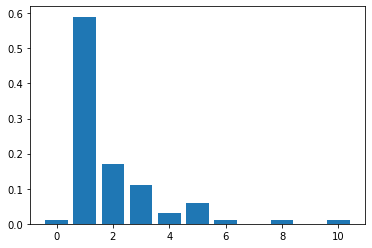

In [17]:
plt.bar(d_len_occurrences.keys(), d_len_occurrences.values())

## Grid explorations

### ExploreGridProfilesOrdinal

Here, we examine all examples with a given denominator in the profile. For example, if $\textrm{denominator} = 9$, we will examine profiles such as $(1/9, 2/9, 2/9, 1/9, 1/3, 0)$ or $(1/9, 5/9, 0, 3/9, 0, 0)$, etc.

Beforehand, we may define a test function that indicates what kinds of profiles we want to study. In this example, we restrict to Condorcet profiles that have at least a utility-dependent equilibrium.

In [18]:
def test_condorcet_with_utility_dependent(profile):
    return(
        profile.is_profile_condorcet == 1.0
        and len(profile.analyzed_strategies.utility_dependent) > 0
    )

N.B.: as in the example above, it is better to put the fast tests (here, is_profile_condorcet) before the slow tests (here, having no true equilibrium). It speeds up the program significantly.

Launch the exploration:

In [19]:
exploration = pa.ExploreGridProfilesOrdinal(
    denominator=3, test=test_condorcet_with_utility_dependent)
exploration

0 equilibrium, 1 utility-dependent equilibrium, 3 non-equilibria
<abc: 2/3, cab: 1/3> (Condorcet winner: a)

0 equilibrium, 1 utility-dependent equilibrium, 7 non-equilibria
<abc: 1/3, acb: 1/3, bac: 1/3> (Condorcet winner: a)

0 equilibrium, 2 utility-dependent equilibria, 2 non-equilibria
<abc: 2/3, cba: 1/3> (Condorcet winner: a)
<abc: 2/3, bca: 1/3> (Condorcet winner: a)

0 equilibrium, 3 utility-dependent equilibria, 5 non-equilibria
<abc: 1/3, acb: 1/3, bca: 1/3> (Condorcet winner: a)

2 equilibria, 1 utility-dependent equilibrium, 5 non-equilibria
<abc: 1/3, bac: 1/3, cab: 1/3> (Condorcet winner: a)

Access one profile in particular in order to study it:

In [20]:
profile = exploration[(0, 1, 3)][0]
profile

<abc: 2/3, cab: 1/3> (Condorcet winner: a)

If the test breaks the symmetry between candidates, you should use the option $\verb|standardized = False|$:

In [21]:
def test_a_is_condorcet_winner(profile):
    return 'a' in profile.condorcet_winners
exploration = pa.ExploreGridProfilesOrdinal(
    test=test_a_is_condorcet_winner, denominator=2, standardized=False)
exploration

0 equilibrium, 1 utility-dependent equilibrium, 3 non-equilibria
<bac: 1/2, cab: 1/2> (Condorcet winner: a, b, c)
<acb: 1/2, cba: 1/2> (Condorcet winner: a, c)
<acb: 1/2, bca: 1/2> (Condorcet winner: a, b, c)
<acb: 1/2, bac: 1/2> (Condorcet winner: a, b)
<abc: 1/2, cba: 1/2> (Condorcet winner: a, b, c)
<abc: 1/2, cab: 1/2> (Condorcet winner: a, c)
<abc: 1/2, bca: 1/2> (Condorcet winner: a, b)

1 equilibrium, 0 utility-dependent equilibrium, 1 non-equilibrium
<acb: 1> (Condorcet winner: a)
<abc: 1> (Condorcet winner: a)

1 equilibrium, 0 utility-dependent equilibrium, 3 non-equilibria
<acb: 1/2, cab: 1/2> (Condorcet winner: a, c)
<abc: 1/2, bac: 1/2> (Condorcet winner: a, b)
<abc: 1/2, acb: 1/2> (Condorcet winner: a)

### ExploreGridTaus

Define a test and explore:

In [22]:
def test_direct_focus(tau):
    return tau.focus == pa.Focus.DIRECT
exploration = pa.ExploreGridTaus(
    denominator=6, test=test_direct_focus)
exploration

<a: 1/3, ab: 1/6, bc: 1/2> ==> b
<a: 1/3, b: 1/6, bc: 1/2> ==> b
<a: 1/3, ab: 1/6, ac: 1/3, b: 1/6> ==> a
<a: 1/3, ac: 1/6, b: 1/3, c: 1/6> ==> a
<a: 1/2, ab: 1/3, ac: 1/6> ==> a
<a: 1/2, ac: 1/3, b: 1/6> ==> a
<a: 1/2, ab: 1/6, b: 1/6, c: 1/6> ==> a

Access one tau in particular in order to study it:

In [23]:
tau = exploration[0]
tau

<a: 1/3, ab: 1/6, bc: 1/2> ==> b

## Meta-Analysis: NiceStatsProfileOrdinal

Define a protocol of meta-analysis:

(For more detailed information, cf. Reference section.)

In [24]:
nice_stats = pa.NiceStatsProfileOrdinal(
    tests_profile=[
        (lambda profile: any([strategy for strategy in profile.analyzed_strategies.equilibria
                              if strategy.profile.condorcet_winners == strategy.winners]),
         'There exists a true equilibrium electing the CW'),
    ],
    tests_strategy=[
        (lambda strategy: strategy.profile.condorcet_winners == strategy.winners,
         'There exists an equilibrium that elects the CW')
    ],
    tests_strategy_dist=[
        (lambda strategy: strategy.profile.condorcet_winners == strategy.winners,
         'There exists an equilibrium that elects the CW')
    ],
   conditional_on=lambda profile: profile.is_profile_condorcet == 1.
)

Run the Monte-Carlo simulation:

In [25]:
nice_stats.run(n_samples=10)

Synthetic view of the results:

P(There exists a true equilibrium electing the CW) = 0.3


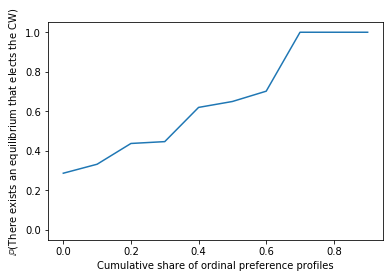

P(There exists an equilibrium that elects the CW) :
{0: 0.35256736660427923, 1: 0.359330859666798, 2: 0.26584798415185057, 3: 0.021822633949336805, 4: 0.00043115562773537314}


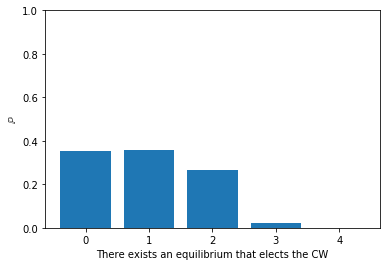

In [26]:
nice_stats.display_results()

Find an example for one of the tests:

In [27]:
profile = nice_stats.find_example('There exists a true equilibrium electing the CW', False)
profile

<abc: 0.2388086819970794, acb: 0.11559069041391623, bac: 0.10383978106355007, bca: 0.04305776492003843, cab: 0.09189034424093856, cba: 0.4068127373644773> (Condorcet winner: c)

Draw a plot:

(-0.05, 1.05)

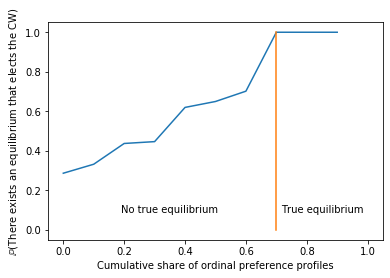

In [28]:
nice_stats.plot_test_strategy('There exists an equilibrium that elects the CW')
nice_stats.plot_cutoff('There exists a true equilibrium electing the CW',
                       left='No true equilibrium', right='True equilibrium')
plt.xlim(-0.05, 1.05)